# AutoML with Text data - Mixed Data Types

## Dealing with Mixed Data Types

In your applications, your text data may be mixed with other common data types like *numerical* data and *categorical* data (which are commonly found in tabular data). The `TextPrediction` task in AutoGluon can train a single neural network that jointly operates on multiple feature types, including text, categorical, and numerical columns. Here we'll again use the [Semantic Textual Similarity](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) dataset to illustrate this functionality.

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Load Data


In [2]:
from autogluon.utils.tabular.utils.loaders import load_pd

train_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/train.parquet')
dev_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/dev.parquet')
train_data.head(10)

Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/train.parquet | Columns = 4 / 4 | Rows = 5749 -> 5749
Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/dev.parquet | Columns = 4 / 4 | Rows = 1500 -> 1500


,sentence1,sentence2,genre,score
0,A plane is taking off.,An air plane is taking off.,main-captions,5.00
1,A man is playing a large flute.,A man is playing a flute.,main-captions,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,main-captions,3.80
3,Three men are playing chess.,Two men are playing chess.,main-captions,2.60
4,A man is playing the cello.,A man seated is playing the cello.,main-captions,4.25
5,Some men are fighting.,Two men are fighting.,main-captions,4.25
6,A man is smoking.,A man is skating.,main-captions,0.50
7,The man is playing the piano.,The man is playing the guitar.,main-captions,1.60
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,main-captions,2.20
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,main-captions,5.00


Note the STS dataset contains two text fields: `sentence1` and `sentence2`, one categorical field: `genre`, and one numerical field `score`. Let's try to predict the **score** based on the other features: `sentence1`, `sentence2`, `genre`.

2020-08-05 11:42:31,723 - root - INFO - All Logs will be saved to ./ag_sts_mixed_score/ag_text_prediction.log
2020-08-05 11:42:31,744 - root - INFO - Train Dataset:
2020-08-05 11:42:31,744 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=4886/0
   length, min/avg/max=16/57.92/367
)
- Text(
   name="sentence2"
   #total/missing=4886/0
   length, min/avg/max=15/57.68/265
)
- Categorical(
   name="genre"
   #total/missing=4886/0
   num_class (total/non_special)=4/3
   categories=['main-captions', 'main-forums', 'main-news']
   freq=[1724, 379, 2783]
)
- Numerical(
   name="score"
   #total/missing=4886/0
   shape=()
)


2020-08-05 11:42:31,745 - root - INFO - Tuning Dataset:
2020-08-05 11:42:31,745 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=863/0
   length, min/avg/max=17/56.48/315
)
- Text(
   name="sentence2"
   #total/missing=863/0
   length, min/avg/max=16/56.69/311
)
- Categorical(
   name="genre"
   #total/missing=863/0
   num_clas

 63%|██████▎   | 383/612 [01:04<00:38,  5.98it/s]


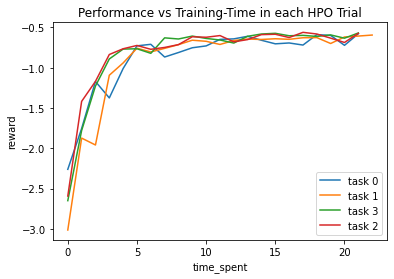

In [3]:
import autogluon as ag
from autogluon import TextPrediction as task

predictor_score = task.fit(train_data,
                           label='score',
                           time_limits=60,
                           ngpus_per_trial=1,
                           seed=123,
                           output_directory='./ag_sts_mixed_score')

In [4]:
score = predictor_score.evaluate(dev_data, metrics=['rmse', 'spearmanr', 'pearsonr'])
print('RMSE=', score['rmse'])
print('Spearman Correlation=', score['spearmanr'])
print('Pearson Correlation=', score['pearsonr'])

RMSE= 0.7751007711455805
Spearman Correlation= 0.8560803284633751
Pearson Correlation= 0.8573700873570499


We can also train a model that predicts **genre** using the other columns as features.

2020-08-05 11:43:49,708 - root - INFO - All Logs will be saved to ./ag_sts_mixed_genre/ag_text_prediction.log
2020-08-05 11:43:49,730 - root - INFO - Train Dataset:
2020-08-05 11:43:49,731 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=4886/0
   length, min/avg/max=16/58.03/367
)
- Text(
   name="sentence2"
   #total/missing=4886/0
   length, min/avg/max=15/57.83/311
)
- Categorical(
   name="genre"
   #total/missing=4886/0
   num_class (total/non_special)=3/3
   categories=['main-captions', 'main-forums', 'main-news']
   freq=[1709, 382, 2795]
)
- Numerical(
   name="score"
   #total/missing=4886/0
   shape=()
)


2020-08-05 11:43:49,731 - root - INFO - Tuning Dataset:
2020-08-05 11:43:49,731 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=863/0
   length, min/avg/max=16/55.89/196
)
- Text(
   name="sentence2"
   #total/missing=863/0
   length, min/avg/max=15/55.84/197
)
- Categorical(
   name="genre"
   #total/missing=863/0
   num_clas

 55%|█████▍    | 335/612 [01:01<00:50,  5.44it/s]


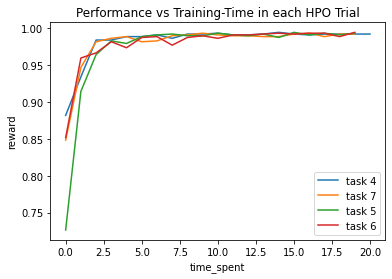

In [5]:
predictor_genre = task.fit(train_data, label='genre',
                           time_limits=60, ngpus_per_trial=1, seed=123,
                           output_directory='./ag_sts_mixed_genre')

In [6]:
score = predictor_genre.evaluate(dev_data, metrics='acc')
print('Genre Accuracy = {}%'.format(score['acc'] * 100))

Genre Accuracy = 83.0%


## What's happening inside?

Internally, there are different sub-networks that each handle different data types, i.e, a TextNet, a CategoricalNet, and a NumericalNet. These networks individually extract separate features from each type of input. Subsequently, an aggregation network combines these learned features and outputs predictions based on their aggregate information.